***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from glob import glob

import category_encoders as ce
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from adabelief_pytorch import AdaBelief
import pytorch_axe as pax
import time
from tqdm import tqdm

import sys
sys.path.append("../utils")
from features import Featurador
from inventory import IDP

pd.set_option('display.max_columns', None)

In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")])+1)
print(SUB_NBR)

22


In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
def compute_rps(preds, targets):
    return np.mean(np.sum((targets - preds)**2, axis=1))
    
set_seed(SEED)

In [7]:
# device in which the model will be trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

***
## data preparation

In [8]:
limit_date = "2021-03-01"

In [9]:
oof = pd.read_csv(f"{results_path}/oof_preds_lgbm-m1.csv")
oof_skus = oof.sku.unique()
len(oof_skus)

482635

In [10]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku in @oof_skus")
    .query("date <= @limit_date")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

482635

In [11]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @oof_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

482635

In [12]:
valid = (
    pd.read_csv(f"{input_path}/validation_seed2.csv")
    .query("sku in @oof_skus")
    .reset_index(drop=True)
)
valid.sku.nunique()

482635

### Build features at sku level 

In [13]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
dataset = feat.transform(dataset)

In [14]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [15]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [16]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

0
0


In [17]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect()

,sku,date,sold_quantity,current_price,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,site_id,product_id,product_family_id,item_domain_id_glob,product_id_glob,product_family_id_glob,q_mean,q_std,was_active,had_sales,tr_points,completeness,minutes_rate1,minutes_rate2,activity_rate1,activity_rate2,sales_rate1,sales_rate2,q_mean_raw,q_std_raw,std_days,std_days_raw
0,1,2021-02-01,0,24.462000,premium,fulfillment,free_shipping,0.0,MLB-SURFBOARD_RACKS,300279,MLB,None,None,SURFBOARD_RACKS,None,None,0.851802,0.850460,False,False,29,1.0,0.270289,0.270289,0.275862,0.275862,0.137931,0.137931,0.241379,0.635563,0.998424,2.633049
1,3,2021-02-01,0,19.950001,premium,fulfillment,free_shipping,1440.0,MLM-RINGS,298603,MLM,None,None,RINGS,None,None,0.342646,0.225240,True,False,29,1.0,0.702826,0.702826,0.724138,0.724138,0.241379,0.241379,0.241379,0.435494,0.657354,1.804190
2,4,2021-02-01,0,14.382000,premium,drop_off,paid_shipping,1440.0,MLB-WEBCAMS,345949,MLB,None,None,WEBCAMS,None,None,1.537417,6.382201,True,False,29,1.0,0.658892,0.658892,0.827586,0.827586,0.482759,0.482759,1.275862,2.519872,4.151250,1.975035
3,6,2021-02-01,0,24.500000,classic,fulfillment,free_shipping,1440.0,MLM-TABLET_CASES,345180,MLM,None,None,TABLET_CASES,None,None,0.655172,0.708680,True,False,29,1.0,1.000000,1.000000,1.000000,1.000000,0.448276,0.448276,0.655172,0.856732,1.081670,1.307644
4,7,2021-02-01,0,17.802000,classic,fulfillment,paid_shipping,0.0,MLB-BEERS,478738,MLB,None,None,BEERS,None,None,2.010820,8.267918,False,False,29,1.0,0.465889,0.465889,0.517241,0.517241,0.275862,0.275862,0.965517,2.243765,4.111714,2.323900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482630,660911,2021-02-01,0,2.575800,classic,fulfillment,paid_shipping,1440.0,MLB-CELLPHONE_PARTS,320792,MLB,None,None,CELLPHONE_PARTS,None,None,0.258822,0.269248,True,False,29,1.0,0.890853,0.890853,0.931034,0.931034,0.206897,0.206897,0.241379,0.510964,1.040283,2.116849
482631,660912,2021-02-01,0,4.950000,classic,fulfillment,paid_shipping,1440.0,MLM-AUTOMOTIVE_EMBLEMS,90441,MLM,None,None,AUTOMOTIVE_EMBLEMS,None,None,0.282363,0.741740,True,False,29,1.0,0.767555,0.767555,0.793103,0.793103,0.137931,0.137931,0.241379,0.786274,2.626903,3.257420
482632,660913,2021-02-01,0,26.982000,premium,drop_off,free_shipping,1440.0,MLB-SOFA_AND_FUTON_COVERS,202580,MLB,None,None,SOFA_AND_FUTON_COVERS,None,None,0.034491,0.033302,True,False,29,1.0,0.999751,0.999751,1.000000,1.000000,0.034483,0.034483,0.034483,0.185695,0.965509,5.385165
482633,660914,2021-02-01,0,9.178200,premium,fulfillment,free_shipping,0.0,MLB-SNEAKERS,490874,MLB,None,None,SNEAKERS,None,None,0.615970,1.386362,False,False,29,1.0,0.839718,0.839718,0.862069,0.862069,0.275862,0.275862,0.517241,1.121883,2.250696,2.168973


0

In [18]:
# inventory days predictions (oof) from the model
predictor = IDP()
predictor.fit(oof)

100%|██████████| 482635/482635 [02:01<00:00, 3986.59it/s]


In [19]:
preds1 = list()
preds2 = list()
for i,row in tqdm(valid.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":valid.sku.values, 
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds = pd.merge(id_preds, valid, how="inner", on="sku")
id_preds

482635it [01:18, 6114.52it/s]


,sku,idp,idp_clip,no_stockout,target_stock,inventory_days
0,1,2.205541,2.205541,0,2,7
1,3,2.399877,2.399877,0,1,30
2,4,-inf,1.000000,0,2,5
3,6,15.127048,15.127048,0,10,24
4,7,21.002023,21.002023,0,39,20
...,...,...,...,...,...,...
482630,660911,inf,30.000000,1,12,24
482631,660912,17.344291,17.344291,0,7,27
482632,660913,16.710365,16.710365,0,2,11
482633,660914,10.362133,10.362133,0,7,18


In [20]:
print("mean ae:", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").mean())
print("median ae", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").median())

mean ae: 7.239609918275016
median ae 5.4104759746024875


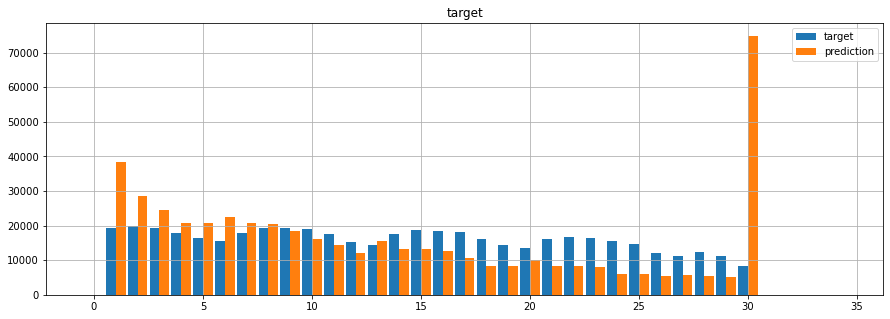

In [21]:
plt.figure(figsize=(15,5))
plt.hist(
    [id_preds.query("inventory_days <= 31").inventory_days.values, 
     id_preds.query("inventory_days <= 31").idp_clip.values], 
    bins=np.arange(0,36), 
    rwidth=0.9, 
    align="left",
    label=["target","prediction"]
)
plt.title("target")
plt.legend(loc="best")
plt.grid()
plt.show()

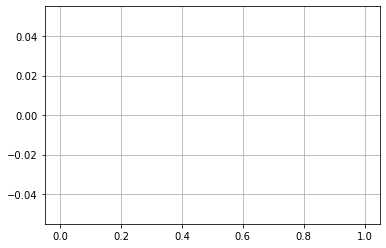

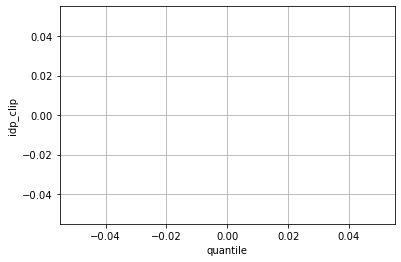

In [22]:
id_preds.query("inventory_days > 30").idp_clip.hist()
plt.show()

id_preds.query("inventory_days > 30").idp_clip.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("idp_clip")
plt.grid()
plt.show()

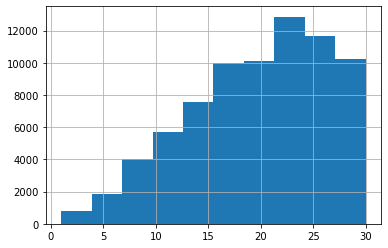

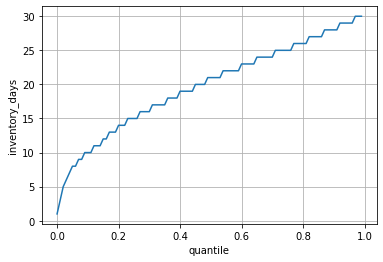

In [23]:
id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.hist()
plt.show()

id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("inventory_days")
plt.grid()
plt.show()

In [24]:
idx = id_preds.query("inventory_days > 31").index
id_preds.loc[idx, "inventory_days"] = 35

idx = id_preds.query("idp > 31").index
id_preds.loc[idx, "idp"] = 35
idx = id_preds.query("idp < 1").index
id_preds.loc[idx, "idp"] = 1

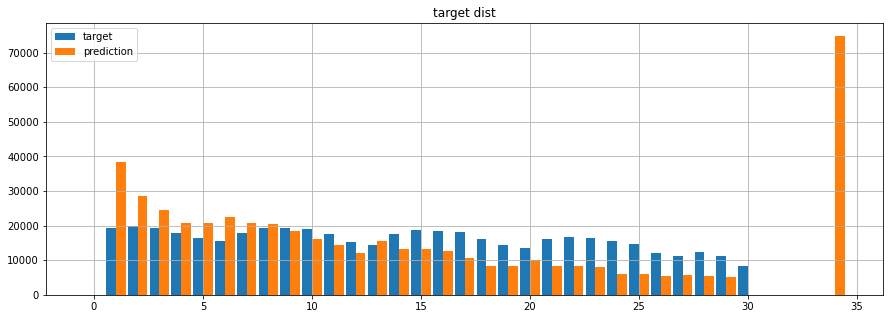

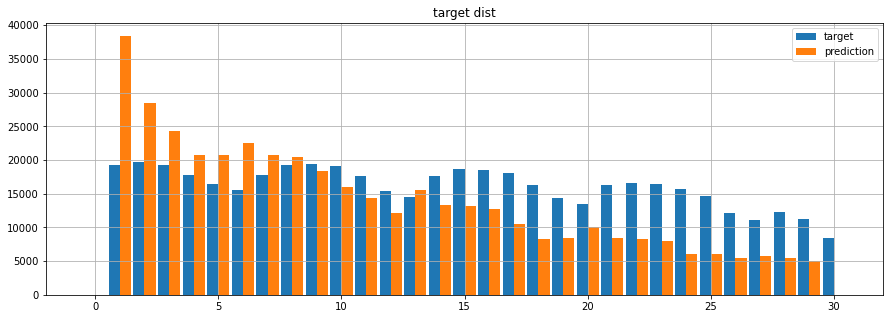

In [25]:
plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,36), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,32), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

In [26]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

sku                            0
date                           0
sold_quantity                  0
current_price                  0
listing_type                   0
shipping_logistic_type         0
shipping_payment               0
minutes_active                 0
item_domain_id                 0
item_id                        0
site_id                        0
product_id                465373
product_family_id         426979
item_domain_id_glob            0
product_id_glob           465373
product_family_id_glob    426979
q_mean                         0
q_std                          0
was_active                     0
had_sales                      0
tr_points                      0
completeness                   0
minutes_rate1                  0
minutes_rate2                  0
activity_rate1                 0
activity_rate2                 0
sales_rate1                    0
sales_rate2                    0
q_mean_raw                     0
q_std_raw                      0
std_days  

In [27]:
input_cols = [
    # sold_quantity stats
    "q_mean",
    "q_mean_raw",
    "q_std",
    "q_std_raw",
    "std_days",
    "std_days_raw",
    
    # activity on history
    "completeness",
    "minutes_rate1",
    "minutes_rate2",
    "activity_rate1",
    "activity_rate2",
    "sales_rate1",
    "sales_rate2",
    # days since no sales
    # days with consecutive sales
    # days since inactive
    # days since active
    
    # ID predictions
    "target_stock",
    "idp_clip",
    "no_stockout",
    "idp_naive1",
    "idp_naive2",
    
    # others
    "site_id",
]
categ_cols = [
    "site_id",
]

print("# feats:", len(input_cols))

# feats: 19


In [28]:
encoder = ce.OneHotEncoder()
transformed = encoder.fit_transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values
for col in categ_cols:
    input_cols.remove(col)
input_cols.extend(transformed.columns.tolist())

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

In [30]:
# for now, we only consider skus that sold their stock
idx = dataset.query("inventory_days > 30").index
dataset = dataset.drop(idx).reset_index(drop=True)
dataset["inventory_days"] = dataset["inventory_days"].astype(int)

print(f"Number of rows removed: {len(idx)}")

Number of rows removed: 0


In [31]:
# generate the target for each sku (cumulative distribution)
y_true = dataset.inventory_days.values.copy()
y_true_one_hot = np.zeros((len(y_true),30), dtype=np.float64)
y_true_one_hot[range(len(y_true)), y_true-1] = 1
y_true = np.cumsum(y_true_one_hot, axis=1)
targets = pd.DataFrame(y_true, index=dataset.sku.values)
targets.index.rename("sku", inplace=True)
targets = targets.reset_index()

***
## model definition

In [32]:
@torch.jit.script
def rps_loss(preds, targets):
    return torch.mean(torch.sum((targets - preds)**2, dim=1))

class DNN(nn.Module):

    def __init__(self, input_dim, output_dim, nn_depth, nn_width, dropout, momentum):
        super().__init__()

        self.bn_in = nn.BatchNorm1d(input_dim, momentum=momentum)
        self.dp_in = nn.Dropout(dropout)        
        self.ln_in = nn.utils.weight_norm(nn.Linear(input_dim, nn_width, bias=False))

        self.bnorms = nn.ModuleList([
            nn.BatchNorm1d(nn_width, momentum=momentum) 
            for i in range(nn_depth-1)
        ])
        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout) 
            for i in range(nn_depth-1)
        ])
        self.linears = nn.ModuleList([
            nn.utils.weight_norm(nn.Linear(nn_width, nn_width, bias=False))
            for i in range(nn_depth-1)
        ])
        
        self.bn_out = nn.BatchNorm1d(nn_width, momentum=momentum)
        self.dp_out = nn.Dropout(dropout/2)
        self.ln_out = nn.utils.weight_norm(nn.Linear(nn_width, output_dim, bias=False))

    def forward(self, x):
        x = self.bn_in(x)
        x = self.dp_in(x)
        x = nn.functional.relu(self.ln_in(x))

        for bn_layer,dp_layer,ln_layer in zip(self.bnorms,self.dropouts,self.linears):
            x = bn_layer(x)
            x = dp_layer(x)
            x = ln_layer(x)
            x = nn.functional.relu(x)
            
        x = self.bn_out(x)
        x = self.dp_out(x)
        x = self.ln_out(x)
        x = nn.functional.softmax(x, dim=1)
        #x = torch.sigmoid(x)
        #x = nn.functional.relu(x)
        #out = nn.functional.sigmoid(x)
        #out_norm = out / torch.reshape(torch.sum(out, dim=1), (-1,1))
        return x
    
    def forward_cum(self, x):
        x = self.forward(x)
        return torch.cumsum(x, dim=1)

    def training_step(self, batch):
        x,y = batch
        y_hat = self.forward_cum(x)
        loss = rps_loss(y_hat, y)
        return loss
    
    def validation_step(self, batch):
        x,y = batch
        y_hat = self.forward_cum(x)
        loss = rps_loss(y_hat, y)
        return loss
    
    def prediction_step(self, batch):
        x,_ = batch
        pred = self.forward(x)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=1e-2, 
            weight_decay=1e-5
        )
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode="min", 
            factor=0.5, 
            patience=5, 
            min_lr=1e-5
        )
        #scheduler = OneCycleLR(
        #    optimizer, 
        #    max_lr=1e0,
        #    epochs=50, 
        #    steps_per_epoch=None, 
        #    pct_start=0.25, 
        #    anneal_strategy='cos', 
        #    div_factor=1e2, 
        #    final_div_factor=1e1,
        #)
        return optimizer,scheduler

***
## model training

In [33]:
len(input_cols)

21

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train model for fold: 1/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            154
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 38%|███▊      | 38/100 [05:19<08:40,  8.40s/it, a_train_loss=4.194511, b_valid_loss=4.076679, c_best_loss=4.076054, g_es_counter=19]


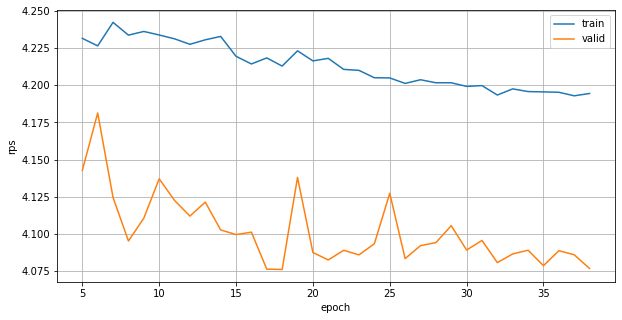

Train model for fold: 2/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            154
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 82%|████████▏ | 82/100 [12:15<02:41,  8.97s/it, a_train_loss=4.195777, b_valid_loss=4.077415, c_best_loss=4.068827, g_es_counter=19]


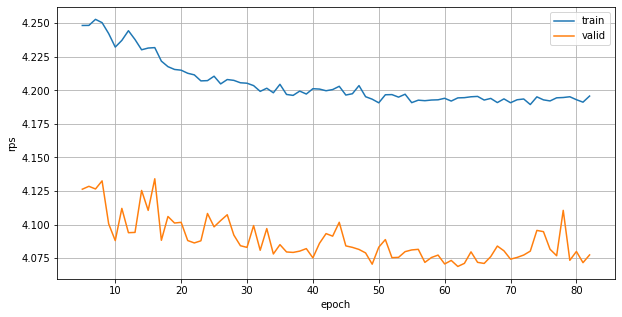

Train model for fold: 3/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            154
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 37%|███▋      | 37/100 [05:17<09:00,  8.58s/it, a_train_loss=4.211606, b_valid_loss=4.113030, c_best_loss=4.099526, g_es_counter=19]


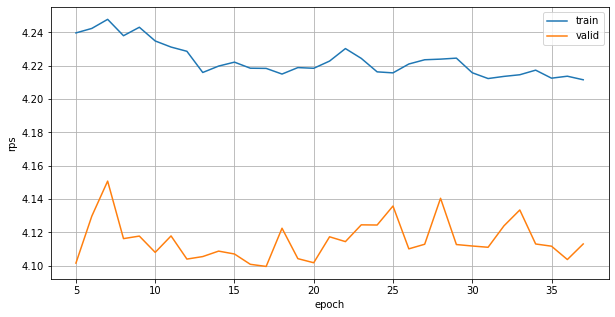

Train model for fold: 4/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            154
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 22%|██▏       | 22/100 [03:23<12:01,  9.25s/it, a_train_loss=4.213126, b_valid_loss=4.120607, c_best_loss=4.095705, g_es_counter=19]


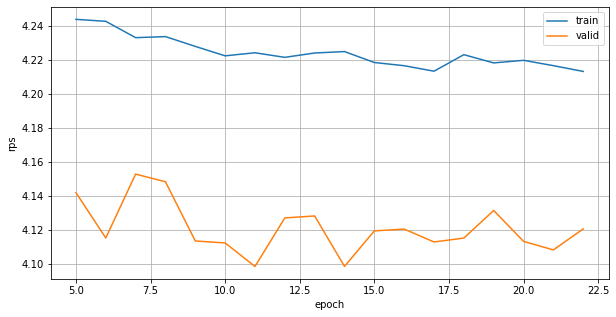

Train model for fold: 5/5


Layer (type:depth-idx)                   Param #
DNN                                      --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            154
├─ModuleList: 1-4                        --
│    └─BatchNorm1d: 2-1                  14
│    └─BatchNorm1d: 2-2                  14
│    └─BatchNorm1d: 2-3                  14
│    └─BatchNorm1d: 2-4                  14
│    └─BatchNorm1d: 2-5                  14
│    └─BatchNorm1d: 2-6                  14
│    └─BatchNorm1d: 2-7                  14
│    └─BatchNorm1d: 2-8                  14
│    └─BatchNorm1d: 2-9                  14
├─ModuleList: 1-5                        --
│    └─Dropout: 2-10                     --
│    └─Dropout: 2-11                     --
│    └─Dropout: 2-12                     --
│    └─Dropout: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Dropout: 2-15                     --
│    └─Dropout: 2-16      

 39%|███▉      | 39/100 [06:20<09:55,  9.76s/it, a_train_loss=4.198724, b_valid_loss=4.045326, c_best_loss=4.034725, g_es_counter=19]


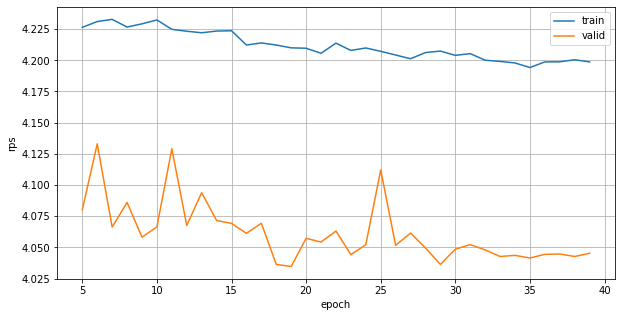

In [34]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
strat_cols = ["item_domain_id", "no_stockout", "inventory_days"]
mskf_split = mskf.split(dataset, dataset[strat_cols])

models_by_fold = list()
oof_preds = list()

for fold,(train_idx,valid_idx) in enumerate(mskf_split):
    print(f"Train model for fold: {fold+1}/5")
    
    x_train = dataset.loc[train_idx,input_cols]
    y_train = targets.iloc[train_idx,1:]
    x_valid = dataset.loc[valid_idx,input_cols]
    y_valid = targets.iloc[valid_idx,1:]
    
    train_dset = TensorDataset(
        torch.tensor(x_train.values, dtype=torch.float),
        torch.tensor(y_train.values, dtype=torch.float),
    )
    valid_dset = TensorDataset(
        torch.tensor(x_valid.values, dtype=torch.float),
        torch.tensor(y_valid.values, dtype=torch.float),
    )
    train_dataloader = DataLoader(
        train_dset, 
        batch_size=1024, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_dset, 
        batch_size=len(valid_dset), 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    model = DNN(
        input_dim=len(input_cols),
        output_dim=30, 
        nn_depth=len(input_cols)//2, 
        nn_width=7, 
        dropout=0.2, 
        momentum=0.1,
    )
    display(torchinfo.summary(model))
    
    model,monitor = pax.iterative_train(
        model, 
        train_dataloader, 
        valid_dataloader, 
        max_epochs=100, 
        patience=20,
        clip_value=0.05,
    )
    model.load_state_dict(monitor.best_model_state)
    models_by_fold.append(model)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5, len(monitor.train_loss)), monitor.train_loss[5:], label="train")
    plt.plot(np.arange(5, len(monitor.valid_loss)), monitor.valid_loss[5:], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("rps")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    preds_proba = pax.iterative_predict(model, valid_dataloader).detach().cpu().numpy()
    preds_proba = pd.DataFrame(preds_proba, index=dataset.loc[valid_idx,"sku"].values)
    oof_preds.append(preds_proba)

In [35]:
oof_preds = pd.concat(oof_preds)
oof_preds = oof_preds.loc[targets.sku.values,:].copy()

In [36]:
# softmax output
assert (targets.sku.values == oof_preds.index.values).all()
print("RPS:", compute_rps(np.cumsum(oof_preds.values, axis=1), targets.iloc[:,1:].values))

RPS: 4.074967269170787


***
## inspecting the predictions

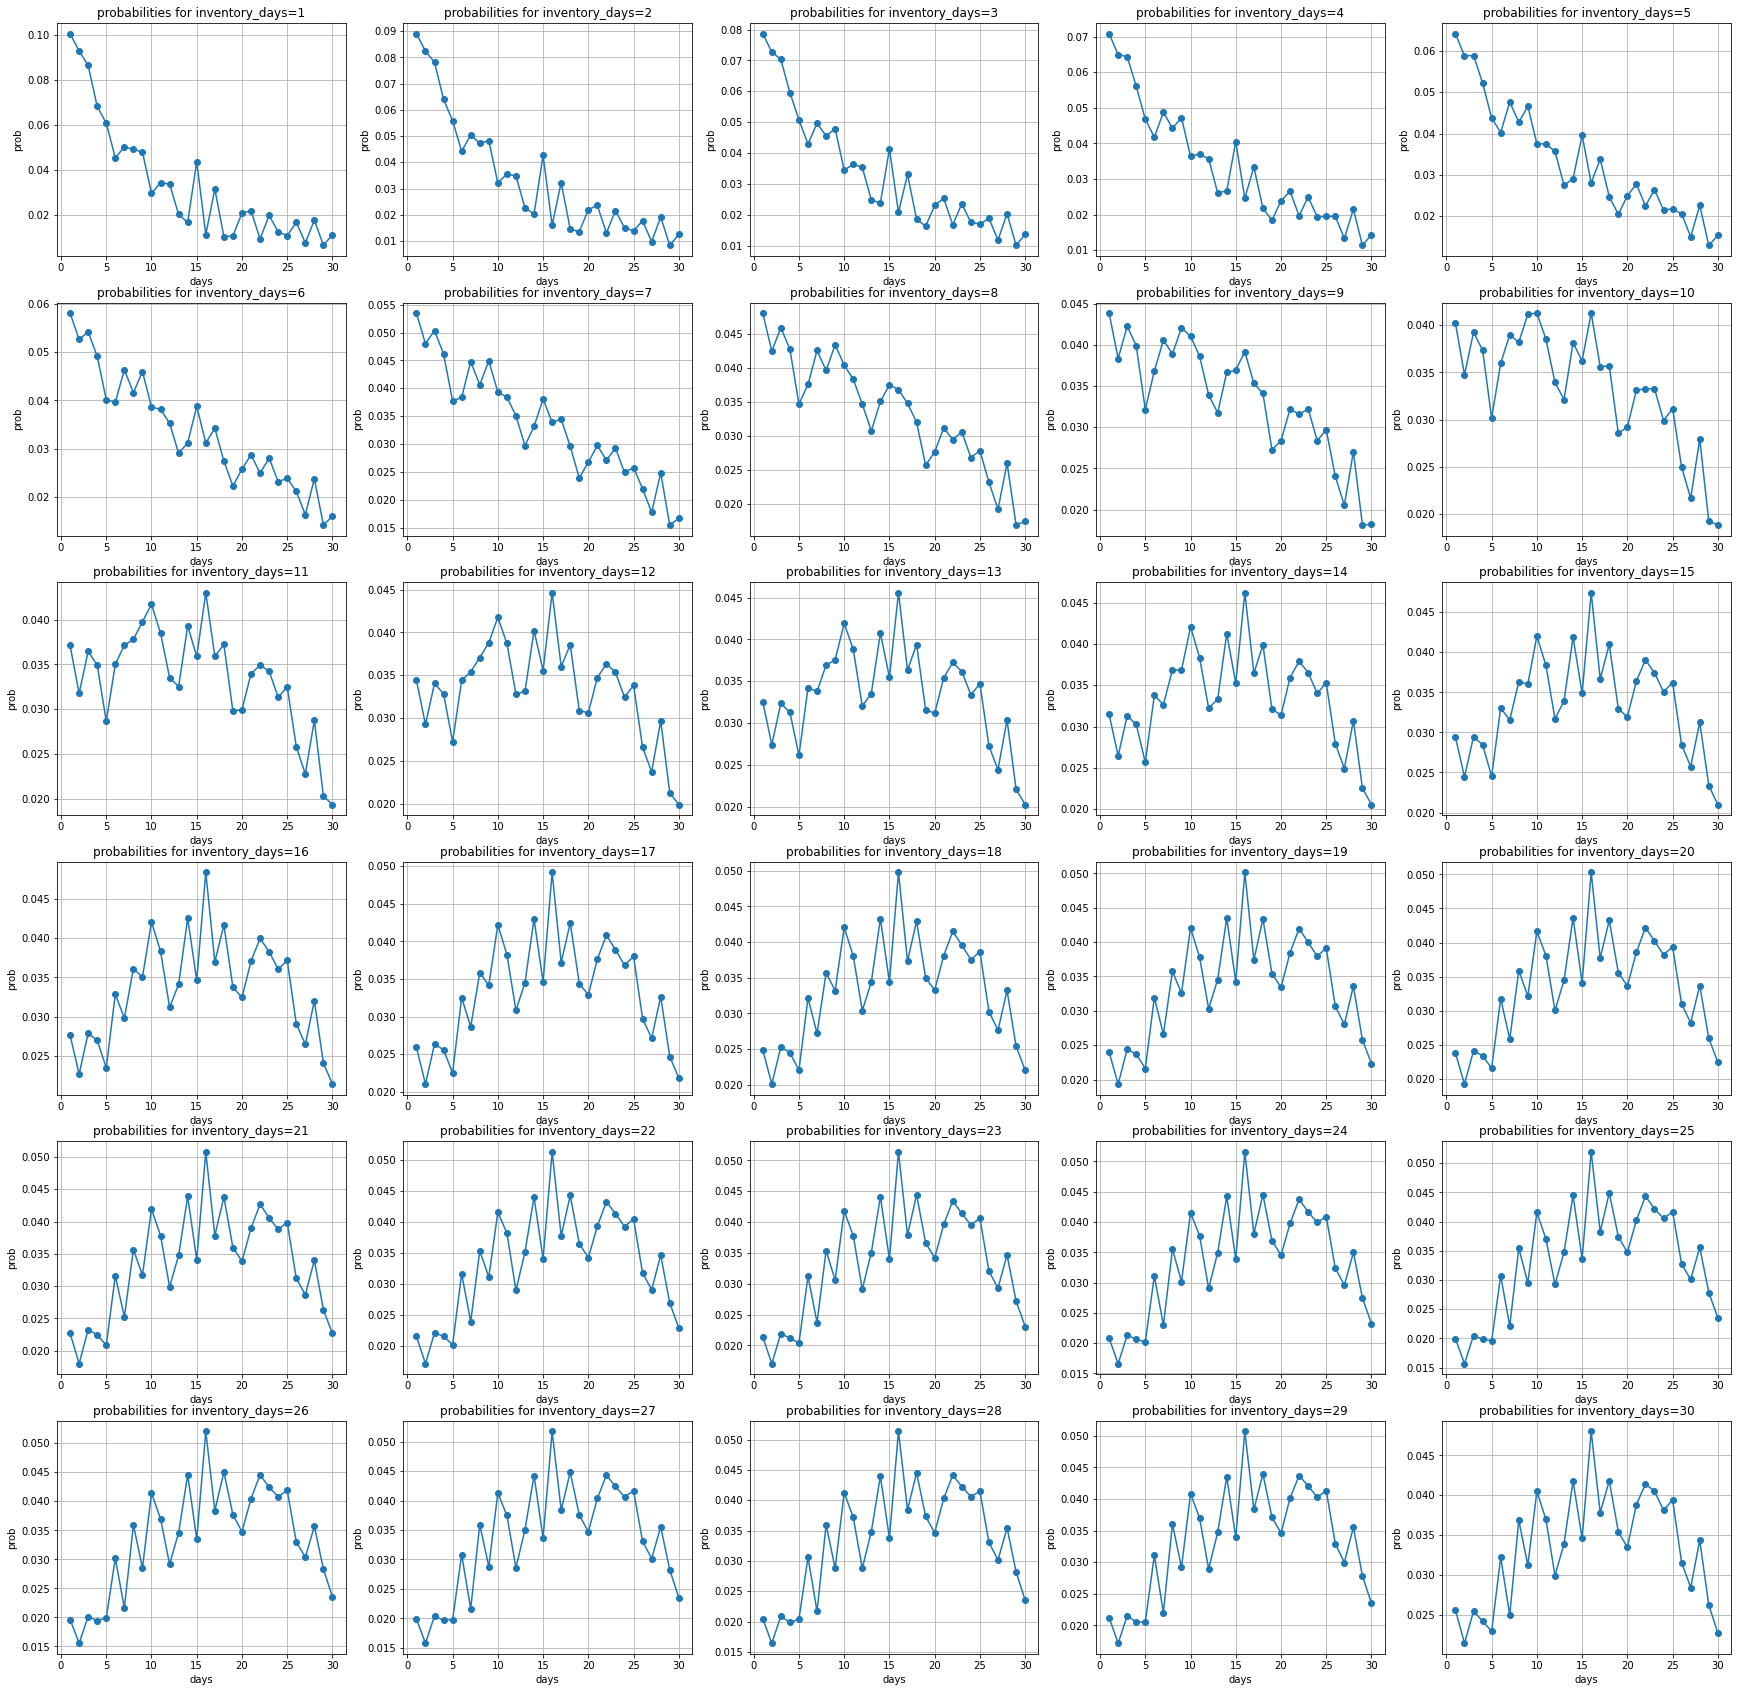

In [37]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    df = valid.query("inventory_days == @idays")
    averaged = oof_preds.loc[df.sku.values].mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"probabilities for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

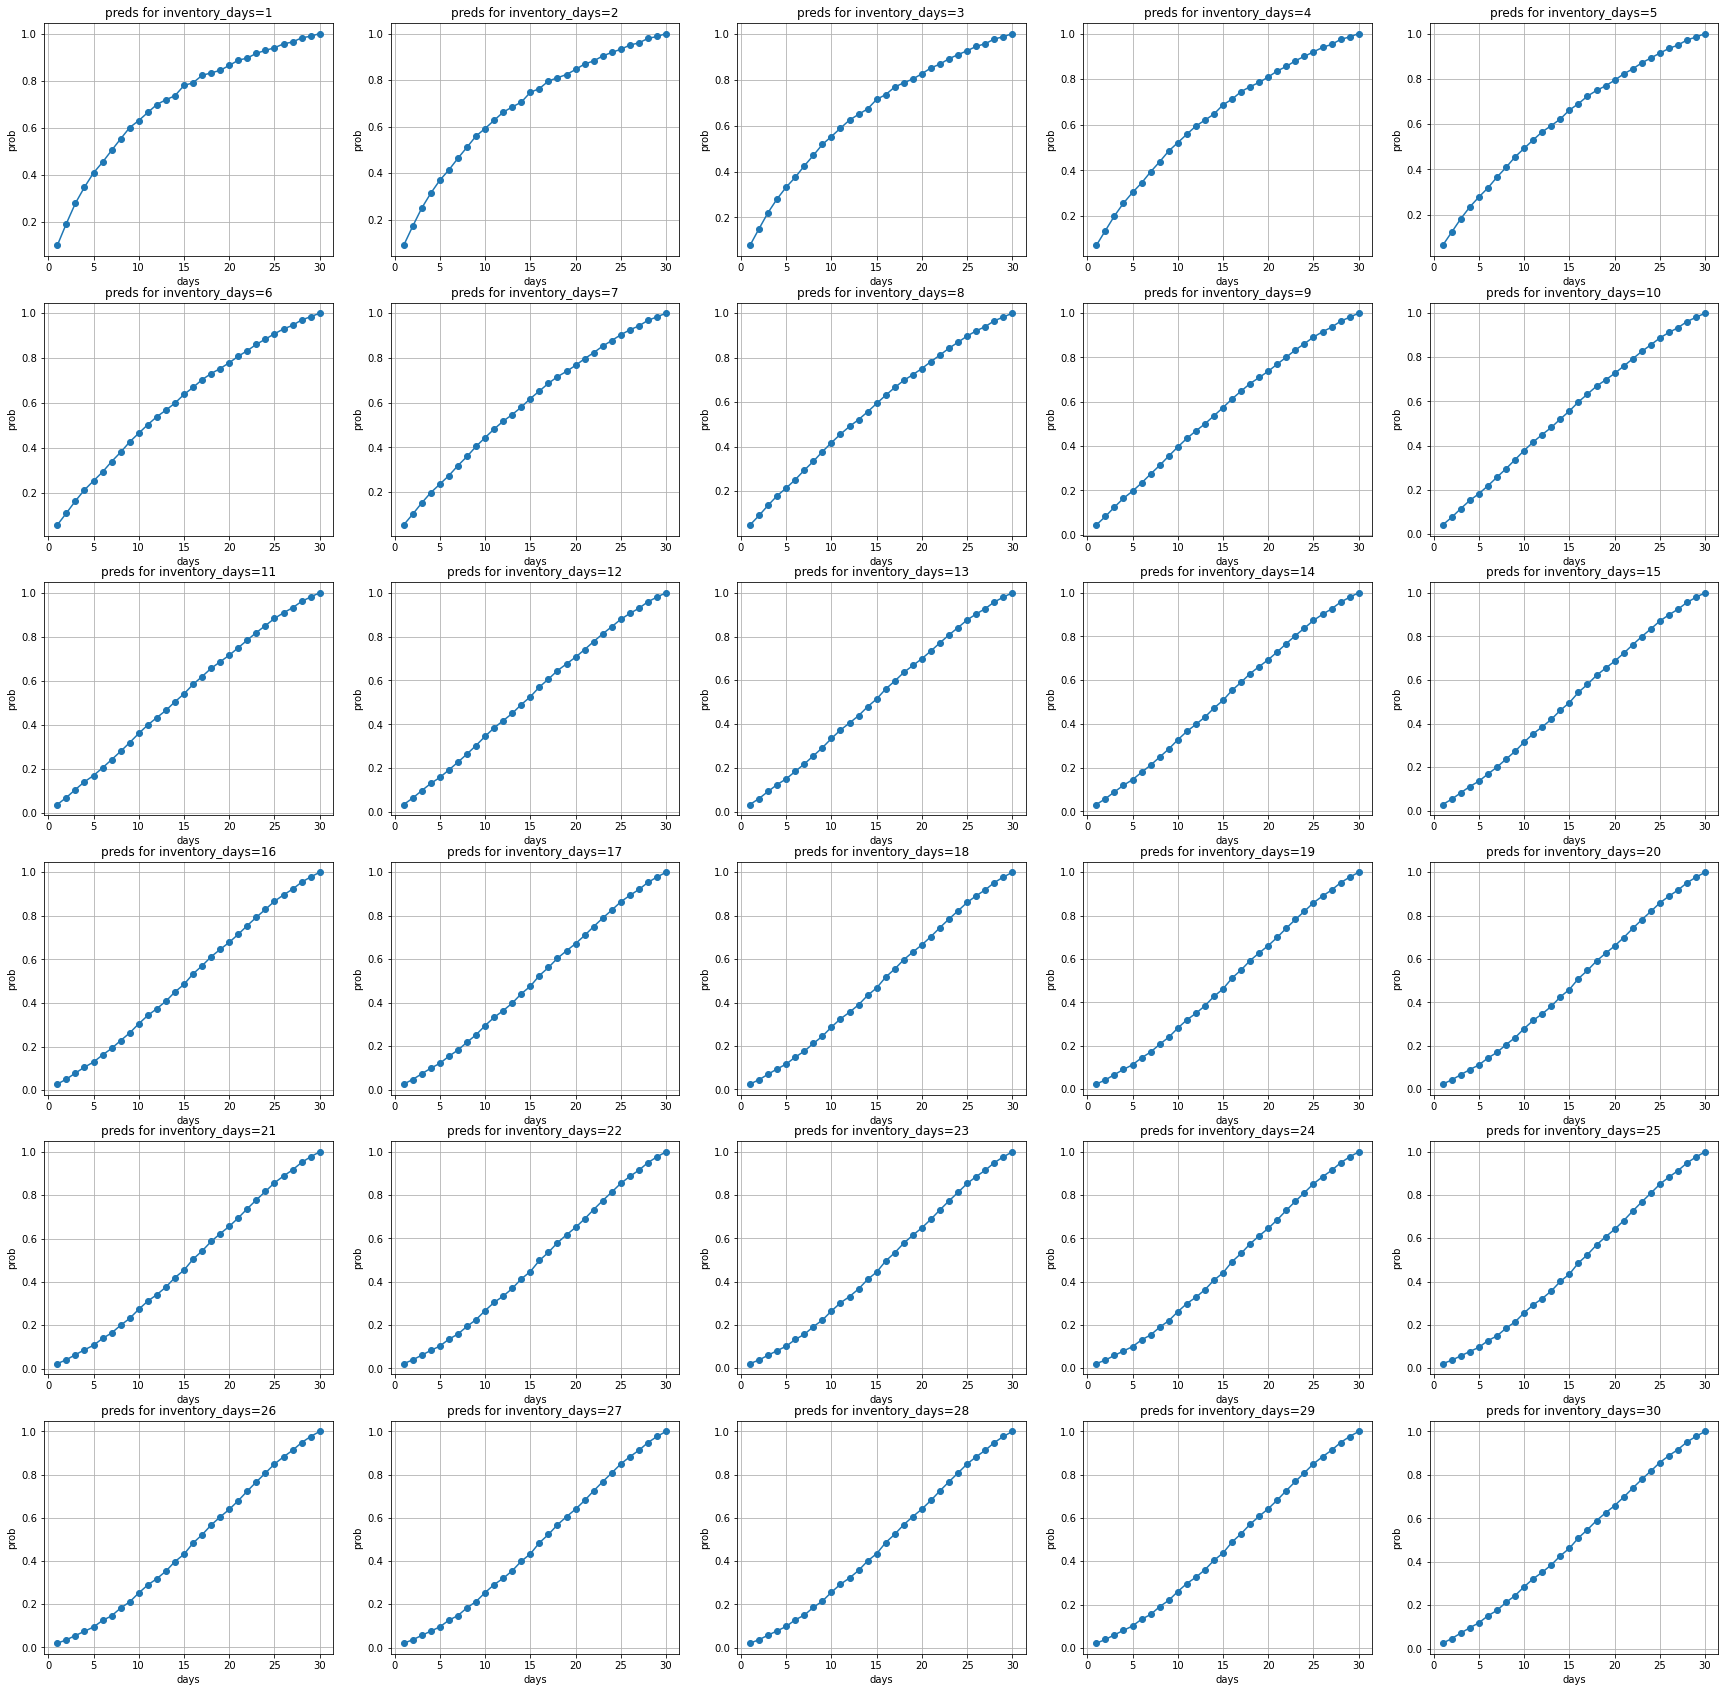

In [38]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    df = valid.query("inventory_days == @idays")
    averaged = np.cumsum(oof_preds.loc[df.sku.values], axis=1).mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"preds for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()


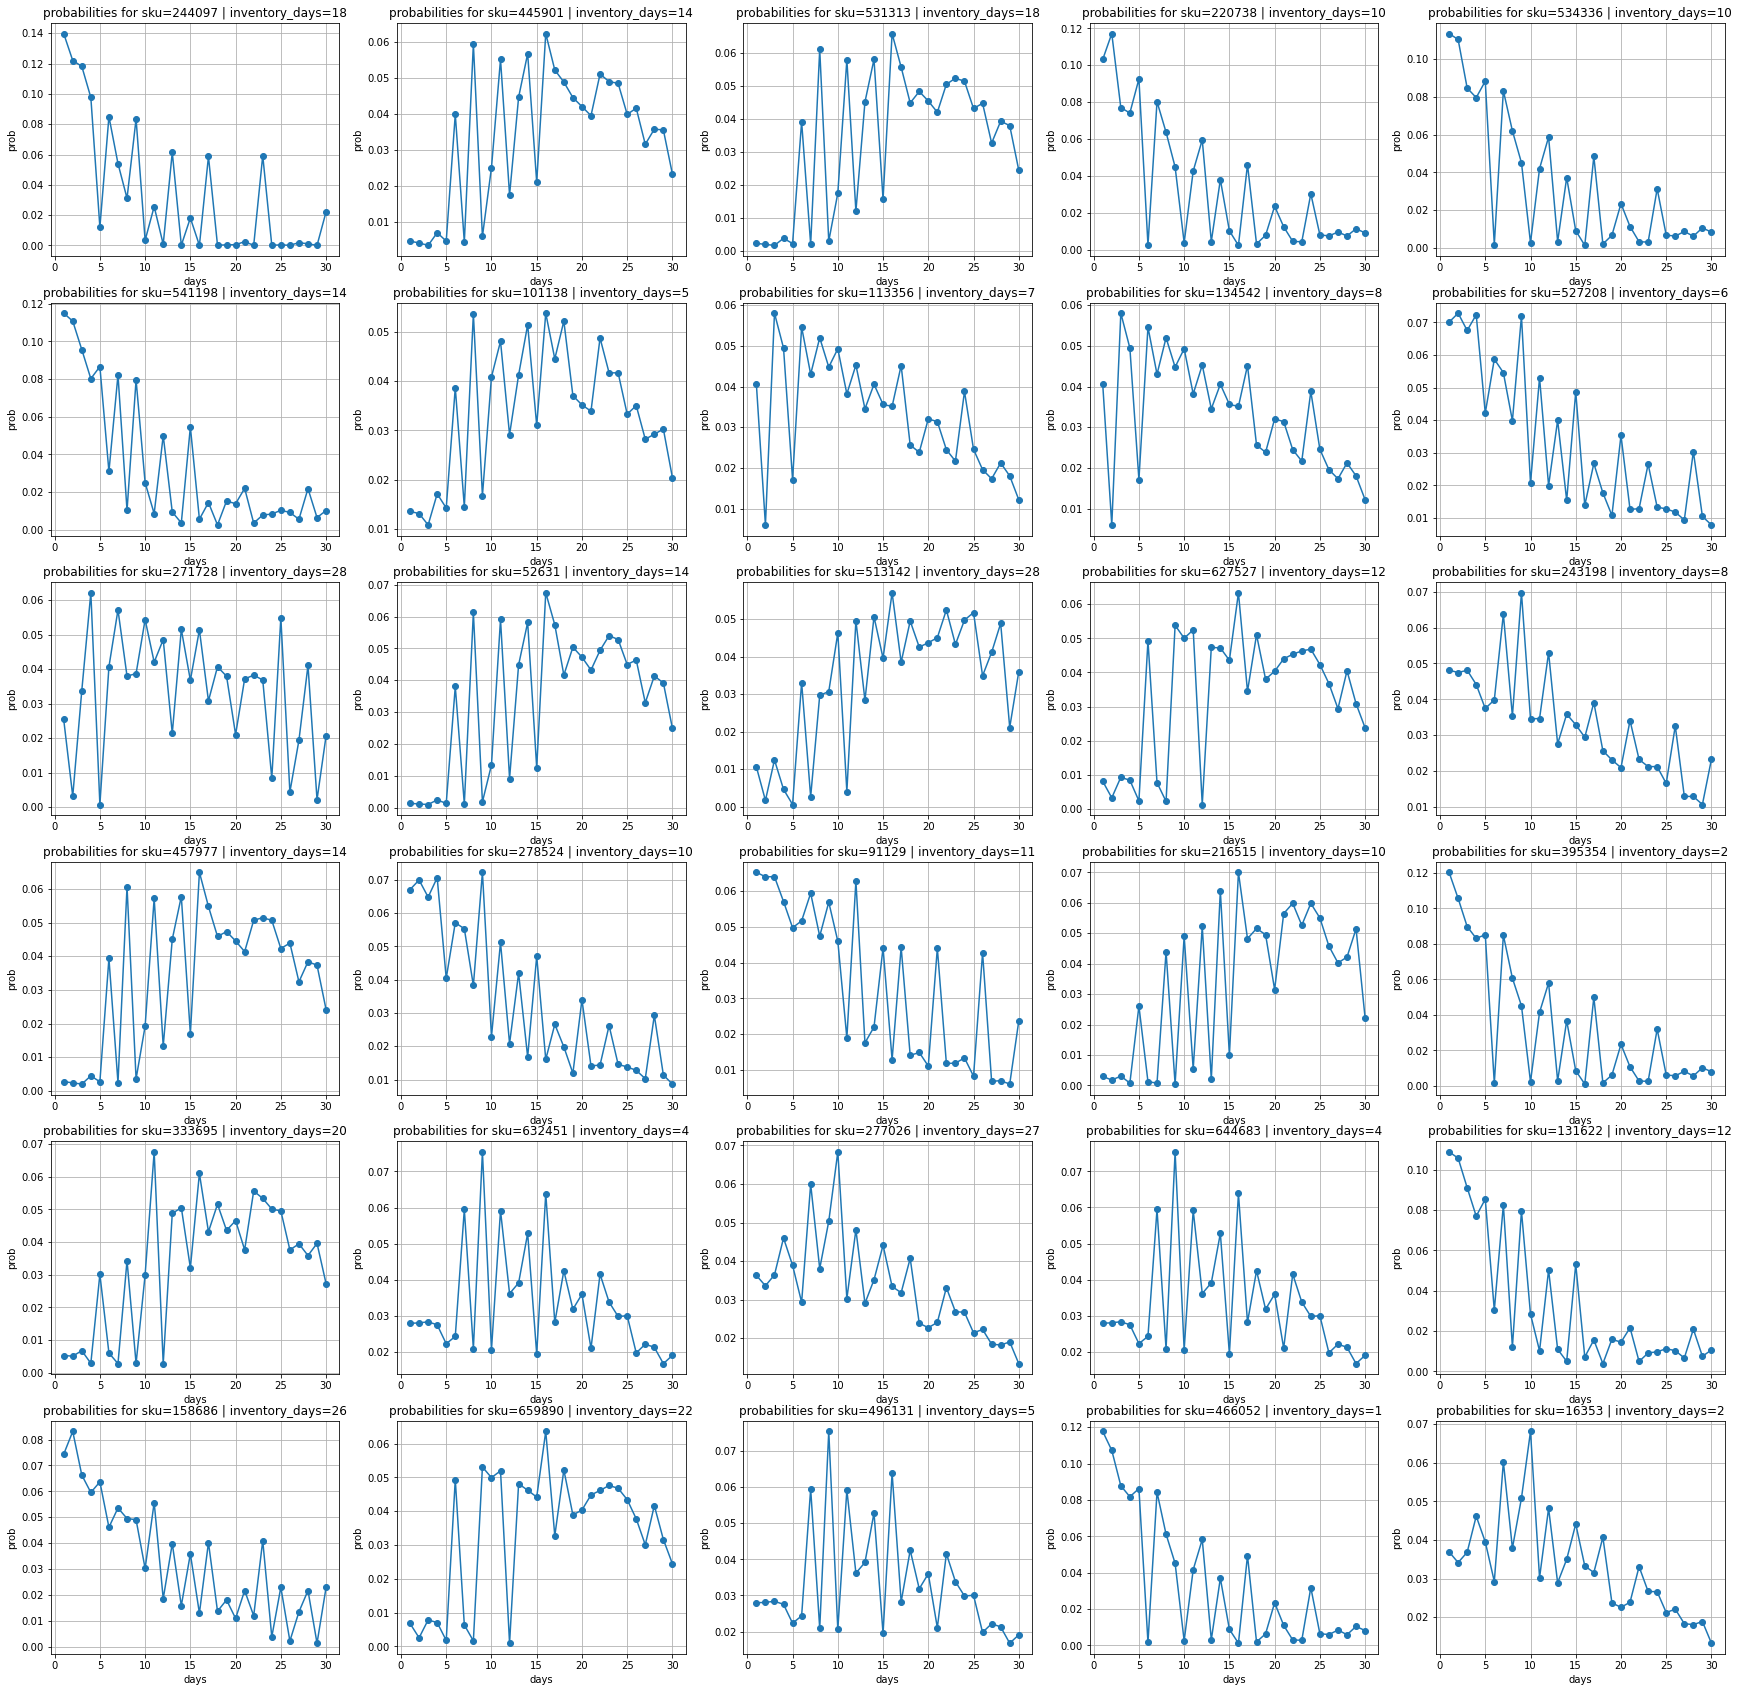

In [39]:
oof_sample = oof_preds.sample(30)

plt.figure(figsize=(30,30))
for i,sku in enumerate(oof_sample.index):
    idays = valid.query("sku == @sku").inventory_days.values[0]
    plt.subplot(6,5,i+1)
    plt.plot(oof_sample.loc[sku].index+1, oof_sample.loc[sku].values, "o-")
    plt.title(f"probabilities for sku={sku} | inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

***
## inference - data preparation

In [40]:
predictions = pd.read_csv(f"{results_path}/preds_m1_lgbm_sub21.csv")
pred_skus = predictions.sku.unique()
len(pred_skus)

526158

In [41]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

526158

In [42]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

526158

In [43]:
test = (
    pd.read_csv(f"{input_path}/test_data.csv")
    .query("sku in @pred_skus")
    .reset_index(drop=True)
)
test.sku.nunique()

526158

In [44]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)

In [45]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [46]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [47]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

0
0


In [48]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect()

,sku,date,sold_quantity,current_price,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,site_id,product_id,product_family_id,item_domain_id_glob,product_id_glob,product_family_id_glob,q_mean,q_std,was_active,had_sales,tr_points,completeness,minutes_rate1,minutes_rate2,activity_rate1,activity_rate2,sales_rate1,sales_rate2,q_mean_raw,q_std_raw,std_days,std_days_raw
0,0,2021-02-01,0,31.102200,classic,cross_docking,free_shipping,0.000000,MLB-SNEAKERS,492155,MLB,None,MLB15832732,SNEAKERS,None,15832732,0.215558,0.482631,False,False,59,1.000000,0.864922,0.864922,0.898305,0.898305,0.101695,0.101695,0.186441,0.655864,2.238988,3.517817
1,1,2021-02-01,0,24.462000,premium,fulfillment,free_shipping,0.000000,MLB-SURFBOARD_RACKS,300279,MLB,None,None,SURFBOARD_RACKS,None,None,0.763534,0.945334,False,False,59,1.000000,0.465593,0.465593,0.474576,0.474576,0.220339,0.220339,0.372881,0.785610,1.238103,2.106863
2,2,2021-03-09,0,14.950000,premium,drop_off,free_shipping,517.583313,MLM-NECKLACES,69847,MLM,None,None,NECKLACES,None,None,0.044724,0.042724,True,False,23,0.389831,0.972149,0.378973,1.000000,0.389831,0.043478,0.016949,0.043478,0.208514,0.955276,4.795832
3,3,2021-02-01,0,19.950001,premium,fulfillment,free_shipping,1440.000000,MLM-RINGS,298603,MLM,None,None,RINGS,None,None,0.316329,0.216265,True,False,59,1.000000,0.427778,0.427778,0.440678,0.440678,0.135593,0.135593,0.135593,0.345295,0.683671,2.546549
4,5,2021-02-01,0,27.934500,premium,fulfillment,free_shipping,0.000000,MLM-RADIO_FREQUENCY_MACHINES,124265,MLM,None,None,RADIO_FREQUENCY_MACHINES,None,None,0.453772,0.429372,False,False,59,1.000000,0.560275,0.560275,0.576271,0.576271,0.203390,0.203390,0.254237,0.544351,0.946228,2.141114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526153,660909,2021-02-01,1,2.695000,classic,fulfillment,paid_shipping,1440.000000,MLA-PENCILS,430327,MLA,None,None,PENCILS,None,None,0.372881,0.471129,True,True,59,1.000000,1.000000,1.000000,1.000000,1.000000,0.305085,0.305085,0.372881,0.692280,1.263482,1.856570
526154,660911,2021-02-01,0,2.575800,classic,fulfillment,paid_shipping,1440.000000,MLB-CELLPHONE_PARTS,320792,MLB,None,None,CELLPHONE_PARTS,None,None,0.385074,0.487071,True,False,59,1.000000,0.812653,0.812653,0.864407,0.864407,0.237288,0.237288,0.322034,0.654972,1.264875,2.033862
526155,660912,2021-02-01,0,4.950000,classic,fulfillment,paid_shipping,1440.000000,MLM-AUTOMOTIVE_EMBLEMS,90441,MLM,None,None,AUTOMOTIVE_EMBLEMS,None,None,0.254217,0.534028,True,False,59,1.000000,0.885747,0.885747,0.898305,0.898305,0.152542,0.152542,0.237288,0.703170,2.100681,2.963358
526156,660913,2021-02-01,0,26.982000,premium,drop_off,free_shipping,1440.000000,MLB-SOFA_AND_FUTON_COVERS,202580,MLB,None,None,SOFA_AND_FUTON_COVERS,None,None,0.185304,0.387188,True,False,59,1.000000,0.861015,0.861015,0.881356,0.881356,0.118644,0.118644,0.169492,0.591682,2.089471,3.490924


293783

In [49]:
# inventory days predictions
predictor = IDP()
predictor.fit(predictions)

preds1 = list()
preds2 = list()
for i,row in tqdm(test.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":test.sku.values, 
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds = pd.merge(id_preds, test, how="inner", on="sku")
id_preds

100%|██████████| 526158/526158 [01:21<00:00, 6477.57it/s]
526158it [01:27, 6010.44it/s]


,sku,idp,idp_clip,no_stockout,target_stock
0,464801,7.621729,7.621729,0,3
1,645793,9.432772,9.432772,0,4
2,99516,4.650056,4.650056,0,8
3,538100,11.493066,11.493066,0,8
4,557191,12.517442,12.517442,0,10
...,...,...,...,...,...
526153,280853,inf,30.000000,1,76
526154,498974,6.802899,6.802899,0,13
526155,63036,inf,30.000000,1,24
526156,317524,21.715046,21.715046,0,8


In [50]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

sku                            0
date                           0
sold_quantity                  0
current_price                  0
listing_type                   0
shipping_logistic_type         0
shipping_payment               0
minutes_active                 0
item_domain_id                 1
item_id                        0
site_id                        0
product_id                505247
product_family_id         463733
item_domain_id_glob            1
product_id_glob           505247
product_family_id_glob    463733
q_mean                         0
q_std                          0
was_active                     0
had_sales                      0
tr_points                      0
completeness                   0
minutes_rate1                  0
minutes_rate2                  0
activity_rate1                 0
activity_rate2                 0
sales_rate1                    0
sales_rate2                    0
q_mean_raw                     0
q_std_raw                      0
std_days  

In [51]:
transformed = encoder.transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values

In [52]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

***
## inference

In [53]:
preds_by_fold = list()

for i,model in enumerate(models_by_fold):
    print(f"Making predictions with model: {i+1}/5")
    
    x_test = dataset.loc[:,input_cols]
    x_test = torch.tensor(x_test.values, dtype=torch.float)
    preds_proba = model(x_test).detach().cpu().numpy()
    preds_by_fold.append(preds_proba)

Making predictions with model: 1/5
Making predictions with model: 2/5
Making predictions with model: 3/5
Making predictions with model: 4/5
Making predictions with model: 5/5


In [54]:
preds_proba = np.mean(preds_by_fold, axis=0)
preds_proba = preds_proba / preds_proba.sum(axis=1).reshape(-1,1)
preds_proba = pd.DataFrame(preds_proba, index=dataset.sku.values)

In [55]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
unpreds_proba = np.ones((len(unpredictable),30)) / 30.
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.108655,0.108558,0.093270,0.076362,0.072417,0.047171,0.053398,0.052598,0.048257,0.024600,0.035530,0.035188,0.015659,0.009928,0.046532,0.002559,0.033054,0.002450,0.006183,0.019145,0.020959,0.002628,0.017832,0.008910,0.005515,0.016369,0.005099,0.015965,0.004239,0.010969
1,0.006543,0.003582,0.007314,0.004443,0.013329,0.026778,0.004448,0.032916,0.019059,0.042944,0.038077,0.023417,0.036770,0.051664,0.032390,0.062523,0.041159,0.053259,0.042563,0.040673,0.044756,0.052542,0.047930,0.049508,0.046814,0.038584,0.035785,0.039543,0.033915,0.026772
2,0.001960,0.000951,0.002142,0.000899,0.011662,0.025266,0.000468,0.035284,0.011593,0.035809,0.031163,0.022309,0.037134,0.045107,0.031262,0.055865,0.041399,0.050047,0.048485,0.039873,0.050013,0.054859,0.054606,0.053192,0.055334,0.044894,0.040991,0.047176,0.040456,0.029804
3,0.031499,0.018765,0.037696,0.041648,0.021934,0.035089,0.057629,0.035884,0.050749,0.050395,0.040711,0.041849,0.036121,0.043389,0.035227,0.046928,0.032910,0.039898,0.028697,0.027501,0.029997,0.034262,0.029377,0.026898,0.031515,0.017762,0.019413,0.024867,0.015460,0.015929
5,0.004576,0.002233,0.005099,0.002713,0.012937,0.025722,0.002163,0.034030,0.017013,0.041258,0.036322,0.022971,0.036010,0.050365,0.031714,0.061399,0.041884,0.052323,0.044490,0.040405,0.046806,0.053780,0.049631,0.051446,0.049186,0.040836,0.037643,0.040959,0.036427,0.027661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458740,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
327670,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393212,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [56]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [57]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [58]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***